# TocoPatch Filter Noise

In [1]:
import pickle
import os
from pprint import pprint
import datetime
import copy
import numpy as np
import scipy.signal
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/Users/doug/Documents/GitHub/LowCostCTG/CombinedRecorder')

In [3]:
from libUC import compressSig, findUC, normalizeUC

In [4]:
from libTocopatchSignal import ProcessUC, isolateUC, UC_DEFAULT_PARAMS

In [5]:
from libFilterUC import filterArtfactsUC, removeSpikes

In [6]:
SelectedRecordings = {
    '135da2bb-0d36-4810-b3f8-ffbc76a43fcf':
        ['ab0fb7c2-dee1-48d6-ba48-2faf23f116b3'],
    '6e688613-e966-458b-8583-5055b2f98634':
        ['3761b754-70d2-4a47-a897-3519daa4632f'],
    '0e01d1dd-c60b-4a0b-b1f7-4b4bb0a6adb4':
        ['54976ba0-228e-435a-8d28-9265984d1379'],
    '5fce3c21-9375-4f5c-b249-875fac0fd6d8':
        ['ddcc6b5b-4933-48a2-9bbd-241e21aeaa40'],
    }

# Code

In [7]:
def showAnnotatedPlot(posMin, uc, filtered, allUC, 
                      thresh_base, thresh, color='b', title='After'):
    
    ymax = np.max(filtered)
    scale = np.max(uc)/ymax
    
    plt.figure(figsize=(15, 2))
    plt.title(title)
    plt.plot(posMin, uc, c=color, lw=1.5)
    plt.plot(posMin, scale*filtered, c='g', alpha=0.25)
        
    plt.plot([0, posMin[-1]], [thresh_base, thresh_base], color+'--')
    plt.plot([0, posMin[-1]], [thresh, thresh], 'r--')

    for j in range(int(posMin[-1])):
        if j % 5 == 0:
            plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.25)
        else:
            plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.1)

    for j in allUC:
        plt.plot([j,j], [-ymax,ymax], color, lw=2)

    plt.xlabel('time in min')
    plt.xlim(posMin[0], posMin[-1])
    plt.ylim(0,np.max(uc))
    plt.show()

In [8]:
def showAllContractions(entries, squelchFactor=5, squelchPercentile=20,
                        minThresh=5, showTiming=False, allN=[25],
                        freq=1.0/25, pct=20, **kwargs):
    print 'kwargs:', kwargs

    for name, key in entries:
        print 'patient key', key
        if key not in SelectedRecordings:
            continue
            
        with open(path+'/'+key+'/recordings_data.p', 'r') as f:
            detail = pickle.load(f)
        if not detail:
            continue
        #if 'deleteme' in name or '6' not in name or 'pt a' not in name:
        if 'deleteme' in name:
            continue

        print '-'*40
        print name, ':'
        for k, v in detail.items():
            
            fname = '{}/{}/{}.p'.format(path, key, v['uuid'])
            print '{}/{}.p'.format(key, v['uuid'])
            #print 'Comments:', data[key]['comment']
            with open(fname, 'r') as f:
                recording = pickle.load(f)

            if 'uc' not in recording or 'pos' not in recording['uc']:
                print
                print '** Skipped '+'*'*40
                print
                continue

            print recording['uc'].keys()
            posSec = recording['uc']['pos']
            posMin = recording['uc']['posMin']

            if len(posSec) == 0 or posMin[-1] < 10:
                print
                print '** Skipped '+'*'*40
                print
                continue

            raw = recording['uc']['raw']
            fs = 1.0/(posSec[1] - posSec[0])

            filtered, uc, alt_uc = isolateUC(raw, fs, **UC_DEFAULT_PARAMS)

            thresh = np.percentile(np.abs(filtered), 95)*2
            if True:
                filteredU = np.copy(filtered)
                filteredU[filteredU > thresh] = thresh
                filteredU[filteredU < 0] = 0

                filteredL = -filtered
                filteredL[filteredL > thresh] = thresh
                filteredL[filteredL < 0] = 0

                filtered = filteredU + filteredL

            ymax = thresh
            for N in allN:
            #for N in [25, 50]:
            #for N in [10, 15, 20, 25]:
                sigOut = removeSpikes(filtered, pct, N, freq=freq)
                base = np.percentile(uc, squelchPercentile)
                squelchMag = max(minThresh, base*squelchFactor)
#                 medUC = np.median(sigOut)
#                 squelchMag = medUC*squelchFactor
                
                allIdx, allUC = findUC(sigOut, posMin)
                if showTiming:
                    _allUC, sustainedUC = filterArtfactsUC(sigOut, posMin, allIdx,
                                                           minMag=squelchMag, **kwargs)
                else:
                    _allUC = []
                    sustainedUC = []
                
                
                showAnnotatedPlot(posMin, sigOut, filtered, _allUC, 
                                  base, squelchMag, title='New Extractor for width {} sec'.format(N*2))


            plt.figure(figsize=(15, 2))
            plt.title('{} -- Filtered Raw Signal'.format(name))
            plt.plot(posMin, filtered)
            for j in range(int(posMin[-1])):
                if j % 5 == 0:
                    plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.5)
                else:
                    plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.1)
            plt.xlabel('time in min')
            plt.xlim(posMin[0], posMin[-1])
            plt.ylim(0,ymax+1)
            plt.show()

            allIdx, allUC = findUC(uc, posMin)
            base = np.percentile(uc, squelchPercentile)
            squelchMag = max(minThresh, base*squelchFactor)

            if minThresh > thresh*squelchFactor:
                print '*** Threshold set to min abs value -- abs: {:0.0f} vs rel: {:0.0f}'.format(
                    minThresh, base*squelchFactor)

            maxVal = np.max(uc)
            if  maxVal < squelchMag:
                print '*** All values below  threshold -- max: {:0.0f} vs thresh: {:0.0f}'.format(
                    maxVal, squelchMag)
            if  maxVal < minThresh:
                print '*** All values below minimum threshold -- max: {:0.0f} vs thresh: {:0.0f}'.format(
                    maxVal, minThresh)

            if showTiming:
                _allUC, sustainedUC = filterArtfactsUC(uc, posMin, allIdx,
                                                       minMag=squelchMag, **kwargs)
            else:
                _allUC=[]
                sustainedUC = []
                
            showAnnotatedPlot(posMin, uc, filtered, _allUC, 
                              base, squelchMag, title='Current Extracted UC')



            print
            print '*'*40
            print

# Analysis

In [9]:
#path = '/Users/doug/Documents/tocopatch_recordings'
#path = '/Users/doug/Documents/GitHub/Malawi_ctg_db'
path = '/Users/doug/Documents/GitHub/Malawi_ctg_db_user2'

In [10]:
with open(path+'/patient_data.p', 'r') as f:
    data = pickle.load(f)

In [11]:
entries = [ ['{} -- {}'.format(v['last_name'].lower(), v['first_name'].lower()), k]
           for k, v in data.items() 
           if v['last_name'].lower() not in ['sample', 'null'] 
           and '3ed0e7e9' not in v['last_name']
           and 'bb3f26f2' not in v['last_name']
          ]
entries = sorted(entries, reverse=True)

kwargs: {'minWidth': 30, 'showSummary': False, 'maxWidth': 78.0, 'verbose': False}
patient key 0afeadbf-577b-45b7-8f60-70a189495752
patient key 135da2bb-0d36-4810-b3f8-ffbc76a43fcf
----------------------------------------
october 4, 2018 -- pt b :
135da2bb-0d36-4810-b3f8-ffbc76a43fcf/ab0fb7c2-dee1-48d6-ba48-2faf23f116b3.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']


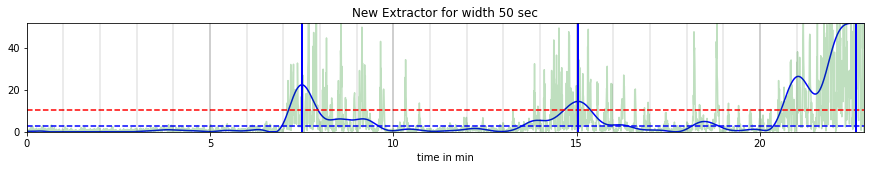

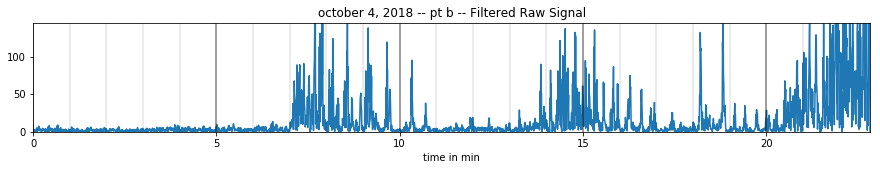

    sustained uc @ 14.7m  width: 97 sec
    sustained uc @ 22.2m  width: 116 sec


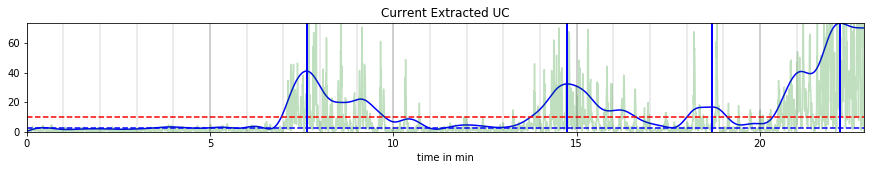


****************************************

patient key 6e688613-e966-458b-8583-5055b2f98634
----------------------------------------
october 4, 2018 -- pt a :
6e688613-e966-458b-8583-5055b2f98634/3761b754-70d2-4a47-a897-3519daa4632f.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']
    sustained uc @  6.9m  width: 95 sec
    sustained uc @ 14.4m  width: 99 sec
    sustained uc @ 20.4m  width: 153 sec


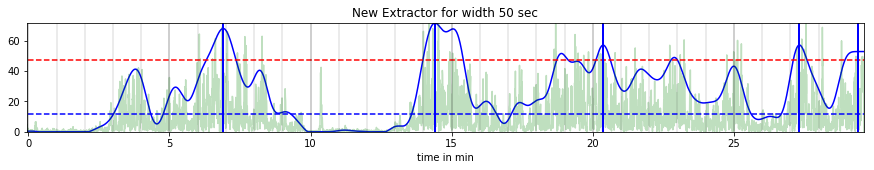

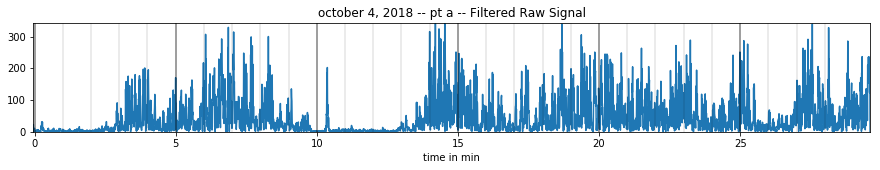

    sustained uc @  6.8m  width: 160 sec
    sustained uc @ 14.3m  width: 103 sec
    sustained uc @ 20.3m  width: 231 sec


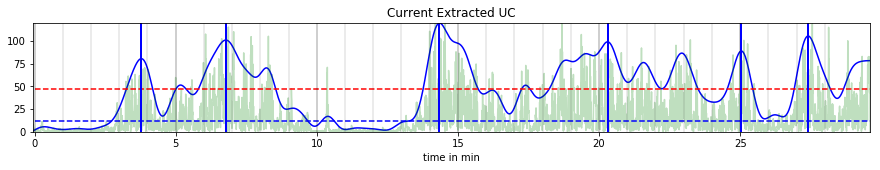


****************************************

6e688613-e966-458b-8583-5055b2f98634/d2d5da0a-a3d9-4411-9363-87af46807e1d.p

** Skipped ****************************************

6e688613-e966-458b-8583-5055b2f98634/9d754e2a-3807-4c96-987f-0d082389aab4.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']

** Skipped ****************************************

patient key c930db20-bcc8-4e1b-a893-627988dfc624
patient key ac488e97-4d2f-4582-bcff-1fb678967c7c
patient key 3d12abdc-e504-4a9c-9ffb-3c5e739fd10e
patient key 3331a782-3057-401c-9c6a-2e0feb7abef2
patient key 5c85bad4-6657-42e0-83ad-a7dc73a5343c
patient key a0f0df7e-87ad-44fd-b01a-d0ba0b6a6705
patient key f7b17628-a4f1-481a-ad6e-1daee0df3734
patient key 906d2e3f-e391-4cbf-a324-4afdfd917574
patient key 57ba7581-81d0-4601-b884-9139fcd98890
patient key 85aeb736-2a1c-4ae4-9cbe-f9caadb935f9
patient key 75ad97ce-1de9-42ee-86ea-cf50acdd194c
patient key 05de685b-e73e-4ada-9a49-b29aa81a4d37
patient key 8963ebcd-cb93-49d0-bd17-e39daf1647d3
patient

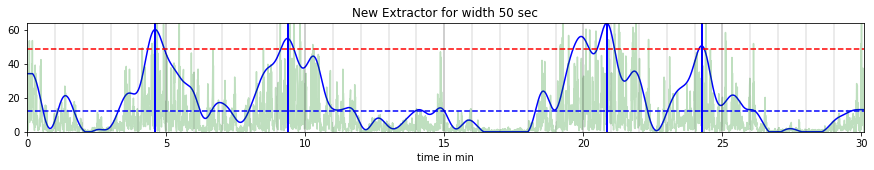

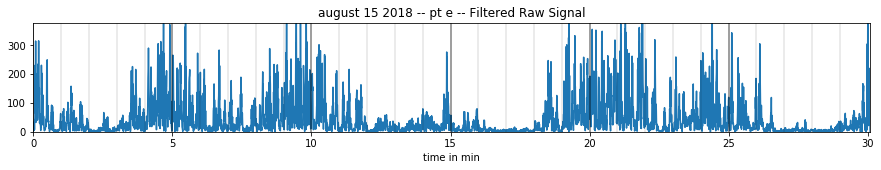

    sustained uc @  4.6m  width: 128 sec
    sustained uc @  9.5m  width: 147 sec
    sustained uc @ 14.9m  width: 88 sec
    sustained uc @ 21.0m  width: 190 sec


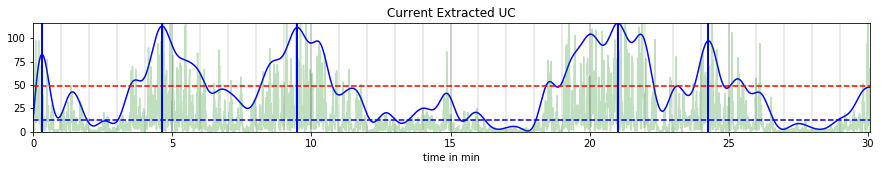


****************************************

patient key 8c00a63c-9a79-4598-935a-66e2c6754404
patient key 0e01d1dd-c60b-4a0b-b1f7-4b4bb0a6adb4
----------------------------------------
august 14, 2018 -- pt d :
0e01d1dd-c60b-4a0b-b1f7-4b4bb0a6adb4/54976ba0-228e-435a-8d28-9265984d1379.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']
    sustained uc @ 12.9m  width: 90 sec


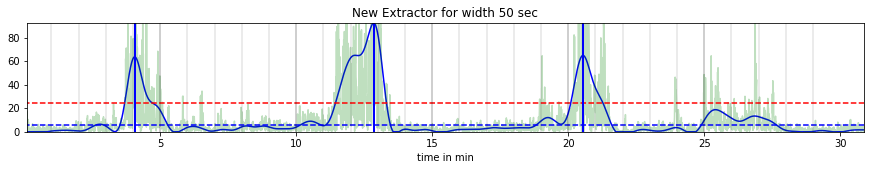

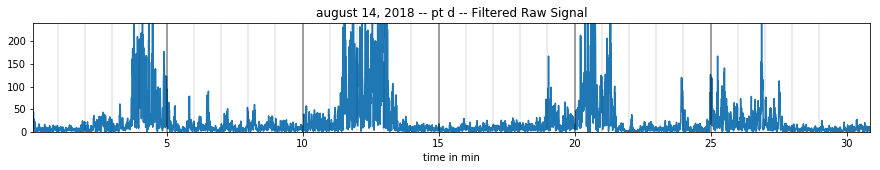

    sustained uc @ 12.9m  width: 110 sec


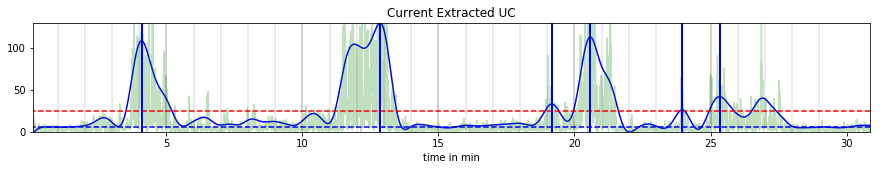


****************************************

patient key 03e235dc-ceae-4946-b4c3-f50eb0b5bf66
patient key 7e87ad11-2020-4df9-8244-201e4b5709a7
patient key 0c3bdd32-4147-4896-9e4f-d8a419cd6852


In [12]:
showAllContractions(entries,
                    # removeSpikes detector  parameters
                    allN=[25],       # evaluation width -- was [25]
                    pct=40,          # percentile magnitude -- was 40
                    freq=1.0/50,     # smoothing freq -- was 1.0/50
                    
                    # peak detector parameters
                    squelchFactor=4,        # threshold as multiple of base
                    squelchPercentile=20,   # percentile for baseline
                    minWidth=30,            # smallest artifact width 
                    maxWidth=60*1.3,        # sustained contraction
                    showTiming=True, 
                    showSummary=False,
                    verbose=False,
                   )

##### 